## Part A: Subreddit Prediction ##

### Q1:baseline

#### 1. data load 

In [0]:
subreddit_train = "coursework_subreddit_train.json"
subreddit_test = "coursework_subreddit_test.json"

!gsutil cp gs://textasdata/coursework/coursework_subreddit_train.json $subreddit_train 
!gsutil cp gs://textasdata/coursework/coursework_subreddit_test.json  $subreddit_test

Copying gs://textasdata/coursework/coursework_subreddit_train.json...
/ [1 files][ 10.1 MiB/ 10.1 MiB]                                                
Operation completed over 1 objects/10.1 MiB.                                     
Copying gs://textasdata/coursework/coursework_subreddit_test.json...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


In [0]:
import pandas as pd

train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)
print(list(train_threads.columns.values))
print(train_threads.head())
print(train_threads.size)

['is_self_post', 'posts', 'subreddit', 'title', 'url']
   is_self_post                                              posts  \
0           1.0  [{'body': 'I think everyone has that one frien...   
1           1.0  [{'body': 'I not 100% sure this is the right p...   
2           1.0  [{'body': '', 'author': 'Leisure321', 'url': '...   
3           1.0  [{'body': 'It's called 'forgetting things'.', ...   
4           1.0  [{'body': 'How would I do this? I am looking t...   

        subreddit                                              title  \
0   relationships  How do I [23F] communicate with my self-center...   
1  summonerschool  What Cherry switch do you recommend for League...   
2       askreddit                   Where do memes go when they die?   
3           trees                     Some weird long term affects??   
4        buildapc  Simple question: If I install Windows to a sta...   

                                                 url  
0  https://www.reddit.com/r/relation

In [0]:
test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)
print(test_threads.head())
print(test_threads.size)

   is_self_post                                              posts  \
0           1.0  [{'body': 'Was watching a VOD from last years ...   
1           1.0  [{'body': 'Basically what the title says.', 'u...   
2           1.0  [{'body': '', 'author': 'Daft-Punk', 'url': 'h...   
3           1.0  [{'body': 'I start running this year. I do it ...   
4           1.0  [{'body': '[deleted]', 'url': 'https://www.red...   

       subreddit                                              title  \
0      starcraft  Just a reminder on how much SC2 has evolved th...   
1    whowouldwin  Your Favorite Hero Now Has A Healing Factor As...   
2      askreddit  If you could live anywhere in the world, where...   
3      askreddit                   Do you ever get use to exercise?   
4  tipofmytongue         [TOMT] [book] A scary french book for kids   

                                                 url  
0  https://www.reddit.com/r/starcraft/comments/mq...  
1  https://www.reddit.com/r/whowouldwin/co

In [0]:
subreddit_counts = train_threads['subreddit'].value_counts()
print(subreddit_counts.describe())
top_subbreddits = subreddit_counts.nlargest(20)
top_subbreddits_list = top_subbreddits.index.tolist()
print(top_subbreddits)

count     20.000000
mean      72.800000
std       73.368285
min       28.000000
25%       36.250000
50%       45.500000
75%       63.750000
max      334.000000
Name: subreddit, dtype: float64
askreddit               334
leagueoflegends         196
buildapc                131
explainlikeimfive        82
trees                    66
techsupport              63
gaming                   62
pcmasterrace             62
electronic_cigarette     59
relationships            48
tipofmytongue            43
jailbreak                38
hearthstone              38
atheism                  37
summonerschool           37
reddit.com               34
movies                   33
whowouldwin              33
personalfinance          32
starcraft                28
Name: subreddit, dtype: int64


#### 2. pre-process
**split validation and test data**

In [0]:
print('Training set contains {:d} posts.'.format(len(train_labels)))
print('Test set contains {:d} posts.'.format(len(test_labels)))

Training set contains 1456 posts.
Test set contains 365 posts.


**get the title, posts and authors**

In [0]:
def extractfunc1(threads):
  opdata=[]
  for thread in threads.itertuples(index=True,name="pandas"):
    postsline=thread[2]
    title=thread[4]
    postext=""
    authors=""
    for post in postsline:
      if post.get("body")!="[deleted]" and post.get("body")!=None and post.get("author")!=None:
        postext+=post["body"]+" "
        authors+=post["author"]+" "
    opdata.append((title,postext,authors))
  output=pd.DataFrame(opdata,columns=["title","posts","author"])
  return output
    
    

In [0]:
train_data=extractfunc1(train_threads)
test_data=extractfunc1(test_threads)
train_data["subreddit"]=train_threads['subreddit']
test_data["subreddit"]=test_threads['subreddit']

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_threads['subreddit'])
train_labels = le.transform(train_threads['subreddit'])
test_labels = le.transform(test_threads['subreddit'])

**Tokenize functions**

In [0]:
import spacy

# Load the medium english model. 
# We will use this model to get embedding features for tokens later.
!python -m spacy download en_core_web_lg

nlp = spacy.load('en_core_web_lg', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



('parser', <spacy.pipeline.DependencyParser at 0x7f208df21150>)

In [0]:
#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.lemma_.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

#@Author split
def author_token(string):
  return string.split(" ")

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Use FeatureUnion to combine the features from text and summary
one_hotpipe= Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer= tokenize_normalize, binary=True)), 
              ])),
            ('posts', Pipeline([
              ('selector', ItemSelector(key='posts')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', CountVectorizer(tokenizer=author_token, binary=True)), 
              ])),
        ])
        )
    ])

tf_idfpipe= Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('posts', Pipeline([
              ('selector', ItemSelector(key='posts')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf-idf', TfidfVectorizer(tokenizer=author_token, binary=False)), 
              ])),
        ])
        )
    ])

In [0]:
train_onehot=one_hotpipe.fit_transform(train_data)
test_onehot=one_hotpipe.transform(test_data)

train_tfidf=tf_idfpipe.fit_transform(train_data)
test_tfidf=tf_idfpipe.transform(test_data)

#### 3. model build
**LR**

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_recall_fscore_support

def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  #precision = precision_score(predictions, true_labels)
  #recall = recall_score(predictions, true_labels)
  accuracy = accuracy_score(predictions, true_labels)
  precision,recall,f1,support=precision_recall_fscore_support(predictions, true_labels,average='macro',beta =1.0)
  #f1 = fbeta_score(predictions, true_labels, 1) #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report( predictions, true_labels, digits=3))	
  #print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted, odd.
  print("================ENDOFEVALUATION=========================\n")

  
def model_evaluation(description, model, train_data, train_labels,test_data,test_labels):
  print("training dataset evaluation:\n")
  evaluation_summary(description, model.predict(train_data), train_labels) 
  print("test dataset evaluation:\n")
  evaluation_summary(description, model.predict(test_data), test_labels) 
  


one-hot

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='saga',multi_class="ovr")
lr.fit(train_onehot,train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
model_evaluation("LR onthot",lr,train_onehot,train_labels,test_onehot,test_labels)

training dataset evaluation:

Evaluation for: LR onthot
Classifier 'LR onthot' has Acc=0.999 P=0.999 R=1.000 F1=0.999
              precision    recall  f1-score   support

           0      1.000     0.997     0.999       335
           1      1.000     1.000     1.000        37
           2      1.000     1.000     1.000       131
           3      1.000     1.000     1.000        59
           4      1.000     1.000     1.000        82
           5      1.000     1.000     1.000        62
           6      1.000     1.000     1.000        38
           7      1.000     1.000     1.000        38
           8      1.000     1.000     1.000       196
           9      1.000     1.000     1.000        33
          10      1.000     1.000     1.000        62
          11      1.000     1.000     1.000        32
          12      0.971     1.000     0.985        33
          13      1.000     1.000     1.000        48
          14      1.000     1.000     1.000        28
          15     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


tf-idf

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='saga',multi_class="ovr")
lr.fit(train_tfidf,train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
model_evaluation("LR tdidf",lr,train_tfidf,train_labels,test_tfidf,test_labels)

training dataset evaluation:

Evaluation for: LR tdidf
Classifier 'LR tdidf' has Acc=0.977 P=0.957 R=0.994 F1=0.975
              precision    recall  f1-score   support

           0      1.000     0.928     0.963       360
           1      0.919     1.000     0.958        34
           2      1.000     0.985     0.992       133
           3      0.983     1.000     0.991        58
           4      0.988     1.000     0.994        81
           5      0.952     1.000     0.975        59
           6      1.000     1.000     1.000        38
           7      1.000     1.000     1.000        38
           8      1.000     0.975     0.987       201
           9      0.848     1.000     0.918        28
          10      0.968     1.000     0.984        60
          11      0.969     1.000     0.984        31
          12      0.912     1.000     0.954        31
          13      1.000     1.000     1.000        48
          14      0.821     1.000     0.902        23
          15      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 **SVM with RBF**
 
 0nehot

In [0]:
from sklearn.svm import SVC
svc = SVC(gamma='auto',decision_function_shape='ovr')
svc.fit(train_onehot,train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
model_evaluation("SVC onthot",svc,train_onehot,train_labels,test_onehot,test_labels)

training dataset evaluation:

Evaluation for: SVC onthot
Classifier 'SVC onthot' has Acc=0.229 P=0.050 R=0.011 F1=0.019
              precision    recall  f1-score   support

           0      1.000     0.229     0.373      1456
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0
          10      0.000     0.000     0.000         0
          11      0.000     0.000     0.000         0
          12      0.000     0.000     0.000         0
          13      0.000     0.000     0.000         0
          14      0.000     0.000     0.000         0
          15   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Evaluation for: SVC onthot
Classifier 'SVC onthot' has Acc=0.230 P=0.050 R=0.012 F1=0.019
              precision    recall  f1-score   support

           0      1.000     0.230     0.374       365
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0
          10      0.000     0.000     0.000         0
          11      0.000     0.000     0.000         0
          12      0.000     0.000     0.000         0
          13      0.000     0.000     0.000         0
          14      0.000     0.000     0.000         0
          15      0.000     0.000     0.000  

td-idf

In [0]:
from sklearn.svm import SVC
svc = SVC(gamma='auto',decision_function_shape='ovr')
svc.fit(train_tfidf,train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
model_evaluation("SVC tdidf",svc,train_tfidf,train_labels,test_tfidf,test_labels)

training dataset evaluation:

Evaluation for: SVC tdidf
Classifier 'SVC tdidf' has Acc=0.229 P=0.050 R=0.011 F1=0.019
              precision    recall  f1-score   support

           0      1.000     0.229     0.373      1456
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0
          10      0.000     0.000     0.000         0
          11      0.000     0.000     0.000         0
          12      0.000     0.000     0.000         0
          13      0.000     0.000     0.000         0
          14      0.000     0.000     0.000         0
          15     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Evaluation for: SVC tdidf
Classifier 'SVC tdidf' has Acc=0.230 P=0.050 R=0.012 F1=0.019
              precision    recall  f1-score   support

           0      1.000     0.230     0.374       365
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0
          10      0.000     0.000     0.000         0
          11      0.000     0.000     0.000         0
          12      0.000     0.000     0.000         0
          13      0.000     0.000     0.000         0
          14      0.000     0.000     0.000         0
          15      0.000     0.000     0.000    

**random-forest.**

onehot

In [0]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier()
rdf.fit(train_onehot,train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
model_evaluation("random forest one-hot",rdf,train_onehot,train_labels,test_onehot,test_labels)

training dataset evaluation:

Evaluation for: random forest one-hot
Classifier 'random forest one-hot' has Acc=0.990 P=0.983 R=0.997 F1=0.990
              precision    recall  f1-score   support

           0      1.000     0.971     0.985       344
           1      1.000     1.000     1.000        37
           2      0.992     0.985     0.989       132
           3      1.000     1.000     1.000        59
           4      0.988     1.000     0.994        81
           5      1.000     1.000     1.000        62
           6      1.000     1.000     1.000        38
           7      1.000     1.000     1.000        38
           8      1.000     0.985     0.992       199
           9      0.939     1.000     0.969        31
          10      0.968     1.000     0.984        60
          11      0.969     1.000     0.984        31
          12      0.941     1.000     0.970        32
          13      0.979     1.000     0.989        47
          14      1.000     1.000     1.000    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


random forest- tfidf

In [0]:
rdf = RandomForestClassifier()
rdf.fit(train_tfidf,train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
model_evaluation("random forest tfidf",rdf,train_tfidf,train_labels,test_tfidf,test_labels)

training dataset evaluation:

Evaluation for: random forest tfidf
Classifier 'random forest tfidf' has Acc=0.995 P=0.994 R=0.999 F1=0.996
              precision    recall  f1-score   support

           0      1.000     0.979     0.990       341
           1      1.000     1.000     1.000        37
           2      1.000     0.992     0.996       132
           3      1.000     1.000     1.000        59
           4      1.000     1.000     1.000        82
           5      1.000     1.000     1.000        62
           6      1.000     1.000     1.000        38
           7      1.000     1.000     1.000        38
           8      0.985     1.000     0.992       193
           9      0.939     1.000     0.969        31
          10      0.984     1.000     0.992        61
          11      1.000     1.000     1.000        32
          12      1.000     1.000     1.000        34
          13      1.000     1.000     1.000        48
          14      1.000     1.000     1.000        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


**Dummy classifier trategy="most_frequent" **

In [0]:
from sklearn.dummy import DummyClassifier
dummy1 = DummyClassifier(strategy="most_frequent")
dummy1.fit(train_onehot, train_labels)
model_evaluation("random forest one-hot",dummy1,train_onehot,train_labels,test_onehot,test_labels)


training dataset evaluation:

Evaluation for: random forest one-hot
Classifier 'random forest one-hot' has Acc=0.229 P=0.050 R=0.011 F1=0.019
              precision    recall  f1-score   support

           0      1.000     0.229     0.373      1456
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0
          10      0.000     0.000     0.000         0
          11      0.000     0.000     0.000         0
          12      0.000     0.000     0.000         0
          13      0.000     0.000     0.000         0
          14      0.000     0.000     0.000    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


**Dummy classifier trategy="stratified"**

In [0]:
from sklearn.dummy import DummyClassifier
dummy1 = DummyClassifier(strategy='stratified')
dummy1.fit(train_onehot, train_labels)
model_evaluation("random forest one-hot",dummy1,train_onehot,train_labels,test_onehot,test_labels)


training dataset evaluation:

Evaluation for: random forest one-hot
Classifier 'random forest one-hot' has Acc=0.101 P=0.047 R=0.047 F1=0.047
              precision    recall  f1-score   support

           0      0.254     0.257     0.256       331
           1      0.027     0.032     0.029        31
           2      0.122     0.127     0.125       126
           3      0.034     0.030     0.032        66
           4      0.049     0.046     0.047        87
           5      0.048     0.051     0.050        59
           6      0.026     0.031     0.029        32
           7      0.026     0.033     0.029        30
           8      0.117     0.118     0.118       195
           9      0.000     0.000     0.000        32
          10      0.048     0.048     0.048        63
          11      0.000     0.000     0.000        35
          12      0.000     0.000     0.000        39
          13      0.083     0.070     0.076        57
          14      0.036     0.038     0.037    

#### Best model evaluation

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='saga',multi_class="ovr")
lr.fit(train_onehot,train_labels)
model_evaluation("LR onthot",lr,train_onehot,train_labels,test_onehot,test_labels)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


training dataset evaluation:

Evaluation for: LR onthot
Classifier 'LR onthot' has Acc=0.999 P=0.999 R=1.000 F1=0.999
              precision    recall  f1-score   support

           0      1.000     0.997     0.999       335
           1      1.000     1.000     1.000        37
           2      1.000     1.000     1.000       131
           3      1.000     1.000     1.000        59
           4      1.000     1.000     1.000        82
           5      1.000     1.000     1.000        62
           6      1.000     1.000     1.000        38
           7      1.000     1.000     1.000        38
           8      1.000     1.000     1.000       196
           9      1.000     1.000     1.000        33
          10      1.000     1.000     1.000        62
          11      1.000     1.000     1.000        32
          12      0.971     1.000     0.985        33
          13      1.000     1.000     1.000        48
          14      1.000     1.000     1.000        28
          15     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig=plt.figure(figsize=(10,10))
    ax = fig.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


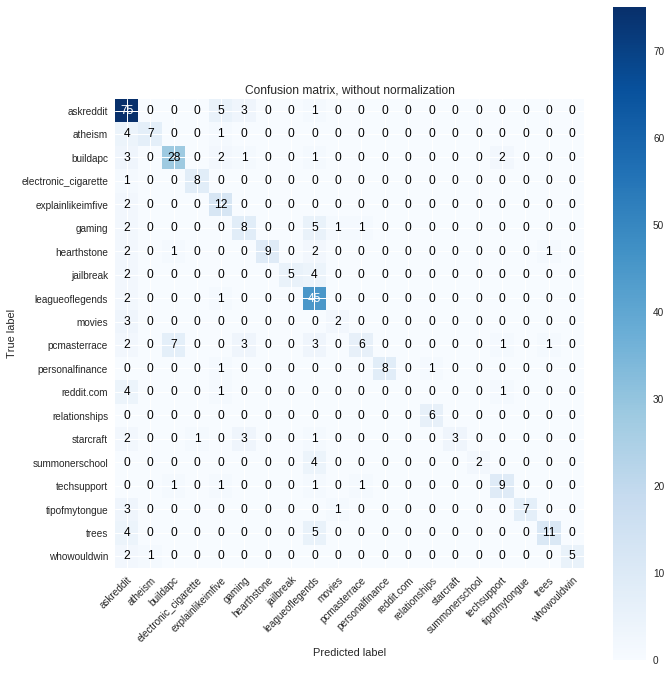

In [0]:
plot_confusion_matrix(test_labels,lr.predict(test_onehot), classes=le.classes_,
                      title='Confusion matrix, without normalization')

In [0]:
precision,recall,f1,support=precision_recall_fscore_support(lr.predict(test_onehot), test_labels,beta =1.0)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[Text(0, 0, 'askreddit'),
 Text(0, 0, 'atheism'),
 Text(0, 0, 'buildapc'),
 Text(0, 0, 'electronic_cigarette'),
 Text(0, 0, 'explainlikeimfive'),
 Text(0, 0, 'gaming'),
 Text(0, 0, 'hearthstone'),
 Text(0, 0, 'jailbreak'),
 Text(0, 0, 'leagueoflegends'),
 Text(0, 0, 'movies'),
 Text(0, 0, 'pcmasterrace'),
 Text(0, 0, 'personalfinance'),
 Text(0, 0, 'reddit.com'),
 Text(0, 0, 'relationships'),
 Text(0, 0, 'starcraft'),
 Text(0, 0, 'summonerschool'),
 Text(0, 0, 'techsupport'),
 Text(0, 0, 'tipofmytongue'),
 Text(0, 0, 'trees'),
 Text(0, 0, 'whowouldwin')]

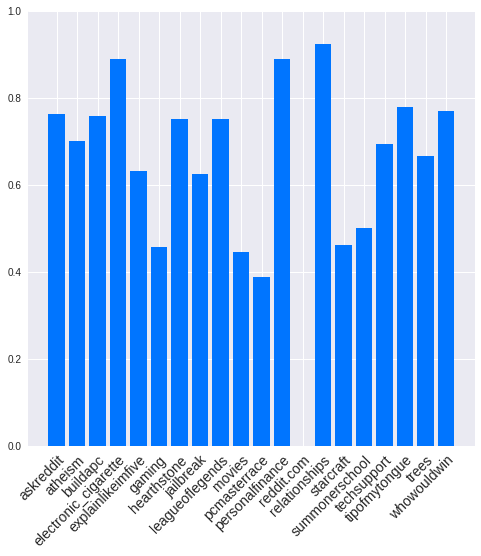

In [0]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.bar(height=f1,x=[x for x in range(20)],color="#0075FF")
ax.set_ylim([0,1])
ax.set_xticks([x for x in range(20)])
ax.set_xticklabels(le.classes_,fontsize=14,rotation=45,ha="right", rotation_mode="anchor")

### Q2:optimization

#### tuning parameters

posts-vectorizer

In [0]:
tf_idfpipe= Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('posts', Pipeline([
              ('selector', ItemSelector(key='posts')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf-idf', TfidfVectorizer(tokenizer=author_token, binary=False)), 
              ])),
        ])
        )
    ])

In [0]:
from scipy.stats import expon
from sklearn.model_selection import GridSearchCV
lr_tune_pipeline=Pipeline([
    ("tfidf",tf_idfpipe),
    ("logistic",LogisticRegression(solver='saga',multi_class="ovr"))
])
params = {
    "tfidf__union__posts__tf-idf__ngram_range":[(1,1),(1,2),(1,3)],
    "tfidf__union__posts__tf-idf__max_features":[None,1000,10000,50000],
    "tfidf__union__posts__tf-idf__sublinear_tf":[True,False],  
}
grid_search = GridSearchCV(lr_tune_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in lr_tune_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'logistic']
parameters:
{'tfidf__union__posts__tf-idf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__union__posts__tf-idf__max_features': [None, 1000, 10000, 50000], 'tfidf__union__posts__tf-idf__sublinear_tf': [True, False]}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 16.4min finished


Best score: 0.344
Best parameters set:
	tfidf__union__posts__tf-idf__max_features: 1000
	tfidf__union__posts__tf-idf__ngram_range: (1, 1)
	tfidf__union__posts__tf-idf__sublinear_tf: False


title-vectorizer

In [0]:
params = {
     "tfidf__union__posts__tf-idf__ngram_range":[(1,1)],
    "tfidf__union__posts__tf-idf__max_features":[1000],
    "tfidf__union__posts__tf-idf__sublinear_tf":[False],  
    "tfidf__union__title__tf-idf__ngram_range":[(1,1),(1,2),(1,3)],
    "tfidf__union__title__tf-idf__max_features":[None,1000,10000,50000],
    "tfidf__union__title__tf-idf__sublinear_tf":[True,False],  
}
grid_search = GridSearchCV(lr_tune_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in lr_tune_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'logistic']
parameters:
{'tfidf__union__posts__tf-idf__ngram_range': [(1, 1)], 'tfidf__union__posts__tf-idf__max_features': [1000], 'tfidf__union__posts__tf-idf__sublinear_tf': [False], 'tfidf__union__title__tf-idf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__union__title__tf-idf__max_features': [None, 1000, 10000, 50000], 'tfidf__union__title__tf-idf__sublinear_tf': [True, False]}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  9.1min finished


Best score: 0.378
Best parameters set:
	tfidf__union__posts__tf-idf__max_features: 1000
	tfidf__union__posts__tf-idf__ngram_range: (1, 1)
	tfidf__union__posts__tf-idf__sublinear_tf: False
	tfidf__union__title__tf-idf__max_features: 1000
	tfidf__union__title__tf-idf__ngram_range: (1, 1)
	tfidf__union__title__tf-idf__sublinear_tf: True


In [0]:
params = {
    "tfidf__union__posts__tf-idf__ngram_range":[(1,1)],
    "tfidf__union__posts__tf-idf__max_features":[1000],
    "tfidf__union__posts__tf-idf__sublinear_tf":[False],  
    "tfidf__union__title__tf-idf__ngram_range":[(1,1)],
    "tfidf__union__title__tf-idf__max_features":[1000],
    "tfidf__union__title__tf-idf__sublinear_tf":[True],  
    "tfidf__union__author__tf-idf__ngram_range":[(1,1),(1,2),(1,3)],
    "tfidf__union__author__tf-idf__max_features":[None,1000,10000,50000],
    "tfidf__union__author__tf-idf__sublinear_tf":[True,False],  
}
grid_search = GridSearchCV(lr_tune_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in lr_tune_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'logistic']
parameters:
{'tfidf__union__posts__tf-idf__ngram_range': [(1, 1)], 'tfidf__union__posts__tf-idf__max_features': [1000], 'tfidf__union__posts__tf-idf__sublinear_tf': [False], 'tfidf__union__title__tf-idf__ngram_range': [(1, 1)], 'tfidf__union__title__tf-idf__max_features': [1000], 'tfidf__union__title__tf-idf__sublinear_tf': [True], 'tfidf__union__author__tf-idf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__union__author__tf-idf__max_features': [None, 1000, 10000, 50000], 'tfidf__union__author__tf-idf__sublinear_tf': [True, False]}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  8.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.387
Best parameters set:
	tfidf__union__author__tf-idf__max_features: None
	tfidf__union__author__tf-idf__ngram_range: (1, 1)
	tfidf__union__author__tf-idf__sublinear_tf: True
	tfidf__union__posts__tf-idf__max_features: 1000
	tfidf__union__posts__tf-idf__ngram_range: (1, 1)
	tfidf__union__posts__tf-idf__sublinear_tf: False
	tfidf__union__title__tf-idf__max_features: 1000
	tfidf__union__title__tf-idf__ngram_range: (1, 1)
	tfidf__union__title__tf-idf__sublinear_tf: True


In [0]:
tf_idfpipe= Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=1000,ngram_range=(1,1),sublinear_tf=True)), 
              ])),
            ('posts', Pipeline([
              ('selector', ItemSelector(key='posts')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=1000,ngram_range=(1,1),sublinear_tf=False)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf-idf', TfidfVectorizer(tokenizer=author_token, binary=False,max_features=None,ngram_range=(1,1),sublinear_tf=True)), 
              ])),
        ])
        )
    ])

In [0]:
params = {
    "logistic__solver":["saga","newton-cg","liblinear"],
    "logistic__C":[10**x for x in range(-3,5)],
    "logistic__multi_class":["ovr"]
    
}
grid_search = GridSearchCV(lr_tune_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in lr_tune_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'logistic']
parameters:
{'logistic__solver': ['saga', 'newton-cg', 'liblinear'], 'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'logistic__multi_class': ['ovr']}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/pyt

Best score: 0.501
Best parameters set:
	logistic__C: 1000
	logistic__multi_class: 'ovr'
	logistic__solver: 'newton-cg'


**drop stopwords modification**

In [0]:
lr_bestmodel_pipeline=Pipeline([
    ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=1000,ngram_range=(1,1),sublinear_tf=True)), 
              ])),
            ('posts', Pipeline([
              ('selector', ItemSelector(key='posts')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=1000,ngram_range=(1,1),sublinear_tf=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf-idf', TfidfVectorizer(tokenizer=author_token, binary=False,max_features=50000,ngram_range=(1,1),sublinear_tf=True)), 
              ])),
        ])
        ),
    ("logistic",LogisticRegression(solver='newton-cg',multi_class="ovr",C=1000))
])

In [0]:
params = {
    "union__posts__tf-idf__stop_words":[None,"english"],
    "union__title__tf-idf__stop_words":[None,"english"],
    "logistic__multi_class":["ovr", "multinomial"]
    
}
grid_search = GridSearchCV(lr_bestmodel_pipeline, param_grid=params, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in lr_bestmodel_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['union', 'logistic']
parameters:
{'union__posts__tf-idf__stop_words': [None, 'english'], 'union__title__tf-idf__stop_words': [None, 'english'], 'logistic__multi_class': ['ovr', 'multinomial']}
Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing.

Best score: 0.553
Best parameters set:
	logistic__multi_class: 'multinomial'
	union__posts__tf-idf__stop_words: 'english'
	union__title__tf-idf__stop_words: None


In [0]:
lr_bestmodel_pipeline=Pipeline([
    ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=1000,ngram_range=(1,1),sublinear_tf=True)), 
              ])),
            ('posts', Pipeline([
              ('selector', ItemSelector(key='posts')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=1000,ngram_range=(1,1),sublinear_tf=True,stop_words='english')), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf-idf', TfidfVectorizer(tokenizer=author_token, binary=False,max_features=50000,ngram_range=(1,1),sublinear_tf=True)), 
              ])),
        ])
        ),
    ("logistic",LogisticRegression(solver='newton-cg',multi_class='multinomial',C=1000))
])

In [0]:
lr_bestmodel_pipeline.fit(train_data,train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('title', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key='title')), ('tf-idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='co...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

In [0]:
precision,recall,f1,support=precision_recall_fscore_support(lr_bestmodel_pipeline.predict(test_data), test_labels,beta =1.0,average="macro")
accuracy = accuracy_score(lr_bestmodel_pipeline.predict(test_data), test_labels)
print("accuracy:",accuracy)
print("precision:",precision)
print("recall:",recall)
print("f1-macro:",f1)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


accuracy: 0.6986301369863014
precision: 0.6674538965427713
recall: 0.7307322826414502
f1-macro: 0.6610959052651207


#### error analysis

Confusion matrix, without normalization


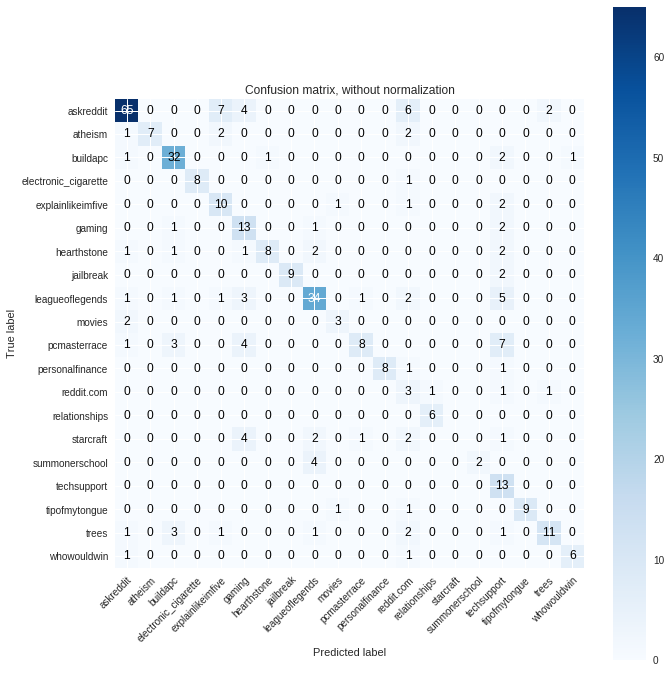

In [0]:
plot_confusion_matrix(test_labels,lr_bestmodel_pipeline.predict(test_data), classes=le.classes_,
                      title='Confusion matrix, without normalization')

In [0]:
print("train_data:============================")
print(classification_report( train_labels,lr_bestmodel_pipeline.predict(train_data), digits=3,target_names=le.classes_))
print("test_data:============================")
print(classification_report(test_labels,lr_bestmodel_pipeline.predict(test_data),  digits=3,target_names=le.classes_))


train_data:============================
                      precision    recall  f1-score   support

           askreddit      1.000     1.000     1.000       334
             atheism      1.000     1.000     1.000        37
            buildapc      1.000     1.000     1.000       131
electronic_cigarette      1.000     1.000     1.000        59
   explainlikeimfive      1.000     1.000     1.000        82
              gaming      1.000     1.000     1.000        62
         hearthstone      1.000     1.000     1.000        38
           jailbreak      1.000     1.000     1.000        38
     leagueoflegends      1.000     1.000     1.000       196
              movies      1.000     1.000     1.000        33
        pcmasterrace      1.000     1.000     1.000        62
     personalfinance      1.000     1.000     1.000        32
          reddit.com      1.000     1.000     1.000        34
       relationships      1.000     1.000     1.000        48
           starcraft      1.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Several errors:

*   class 14: starcraft performs worse, all score is 0.
*  low precision:

>*  explainlikeimfive : 7 askreddit to it

> * gaming : 4 askreddit, 3 summonerschool,  4 starcraft, 4 pcmasterrace

>* reddit.com: 6 ask reddit

>* techsupport: 7 pc 5 leageoflegend


* low recall

>* pcmasterrace  7 to tech 5 to game

>* summonerschool 4 to leageoflegend





For test class 14: starcraft
*   3 are predicted to class 12: reddit.com 
*   2 are predicted to class 16:  techsupport
*   2 are predicted to class 8:  leagueoflegends

class 12:reddit.com. "the original subreddit", content contains several topics, hard to classify.

class 16: techsupport

class 8: both are online-gamings.

The 7th thread which is predicted to it contains Void Ray. Void Ray is a term in StarCraft 2.  When tokenizing, it will be split to void and ray wich is meaningless. As some titles will contain such terms, may be normalization should be re-considered. 

The 4th thread contains SC2 which is definitely a strong word indicates StarCraft 2. But it was nomorlized to 2. Again it indicates the nomorlization is not good



#### Add new features

In [0]:
!pip install vaderSentiment

    100% |████████████████████████████████| 133kB 4.4MB/s 


In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def addvaderSentiment(data):
  vaderSentiment=list()
  for sentence in data['posts']:    
    vs = analyzer.polarity_scores(sentence)
    vaderSentiment.append(vs["compound"])
  data["vaderSentiment"]=vaderSentiment
  

In [0]:
addvaderSentiment(test_data)
addvaderSentiment(train_data)

,title,posts,author,subreddit,vaderSentiment
2,Where do memes go when they die?,Facebook 9gag Memes never truly die Dickbutt ...,Leisure321 Zeolance Buttersgoo23 quzimaa Escap...,askreddit,0.1877
10,Should I tip furniture delivery folk?,"I've purchased a large quantity of furniture, ...",throwaway51711 Lorimor Lorimor GCanuck throwaw...,askreddit,0.5574
16,People of Reddit: What Great Lectures or Talks...,What are some good/interesting talks or lectur...,CalonTost Winkn cantthinkofaCO0Lname badmak ka...,askreddit,0.9878
21,What is a good book to you?,Fear and Loathing in Las Vegas Tales of a four...,Hlaufenberg Noomsi jeffreyharharwood sco154,askreddit,-0.8519
26,If you could only visit 5 websites for the res...,"No loopholes like ""hurr duurrrr I'd choose goo...",French87 LakeAndTheRiver dumandizzy inclinedto...,askreddit,0.5562
27,What is your mental landscape while you dream?,"Places where I go often. Local stores, home, s...",thejumpingasian QwertyPoint TheUnheard blah_bl...,askreddit,0.9790
28,"Sociopaths of Reddit, assuming you have no emp...",Myself. Sociopaths don't necessarily like th...,aminakoydum random_____user elvagabundotonto a...,askreddit,-0.2259
38,"Reddit, how would you take over the world?","If you could be whoever you want, wherever you...",zenflight gtfb96 Not_A_Facehugger goatsanddrag...,askreddit,0.2805
51,"What comes to mind when you hear the word ""moi...",Coffee cake. Vagina flavoured coffee cake. MO...,Slimpikin jbOOgi3 Fogharballs CaneUKRM any_dan...,askreddit,-0.8999
52,"What's your favorite book, show or movie line ...","Basically, whats your favorite quote from some...",Caterkiller slapped_monkey bosssauce316 mybron...,askreddit,0.9466


## Part B: Discourse prediction ##

In [0]:
discourse_train = "coursework_discourse_train.json"
discourse_test = "coursework_discourse_test.json"
  
!gsutil cp gs://textasdata/coursework/coursework_discourse_train.json $discourse_train  
!gsutil cp gs://textasdata/coursework/coursework_discourse_test.json  $discourse_test

In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.
import pandas as pd
import json

def load_posts(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      for post in thread['posts']:
        # NOTE: This could be changed to use additional features from the post or thread.
        # DO NOT change the labels for the test set.
        posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', ""), post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""), # discourse type label 
                        post.get('in_reply_to', "") ))

# Create the posts data frame.  
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to']
  return pd.DataFrame(posts_tmp, columns=labels)

In [0]:
train_posts = load_posts(discourse_train)
# Filter out empty labels
train_posts = train_posts[train_posts['discourse_type'] != ""]
print(train_posts.head())
print("Num posts: ", train_posts.size)

The label for the post we will be predicting is in the discourse_type column.

In [0]:
test_posts = load_posts(discourse_test)
# Filter out empty labels
test_posts = test_posts[test_posts['discourse_type'] != ""]
print("Num posts: ", test_posts.size)


In [0]:
train_labels = train_posts['discourse_type']
test_labels = test_posts['discourse_type']

Examine the distribution over labels on the training data.

In [0]:
discourse_counts = train_labels.value_counts()
print(discourse_counts.describe())

top_discourse = discourse_counts.nlargest(200)
print(top_discourse)
top_discourse = top_discourse.index.tolist()
print(top_discourse)

In [0]:
# Define the features
X_train = #features from training data
X_test = #features from test data

from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(X_train, train_posts['discourse_type'])
predictions = clf.predict(X_test)  
print(classification_report(predictions, test_posts['discourse_type']))